In [2]:
print('hello world')

hello world


In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
plt.rc('savefig', dpi=100)
plt.rc('figure', figsize=(5,5))

In [5]:
import pandas as pd
import requests
import io

In [164]:
ref = pd.read_pickle('ref_sites.pickle')
ref

,nwac_region,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc
site_id,,,,,,,,,,,
651,Mt Hood,SNTL,OR,Mt Hood Test Site (651),NaN,1980-July,45.32,-121.72,5370,Clackamas,Upper Salmon River (170800010302)
974,Olympics,SNTL,WA,Waterhole (974),NaN,1999-October,47.94,-123.43,5010,Clallam,Lillian Creek (171100200506)
998,west-far-north,SNTL,WA,Easy Pass (998),NaN,2008-September,48.86,-121.44,5270,Whatcom,Indian Creek-Chilliwack River (171100010101)
507,east-central,SNTL,WA,Grouse Camp (507),NaN,1980-September,47.28,-120.49,5390,Kittitas,Upper Naneum Creek (170300010401)
679,west-mid-south,SNTL,WA,Paradise (679),NaN,1980-September,46.78,-121.75,5130,Pierce,Headwaters Nisqually River (171100150104)
599,east-far-south,SNTL,WA,Lost Horse (599),NaN,1989-October,46.36,-121.08,5120,Yakima,Upper Simcoe Creek (170300030302)


# Download USDA data

TODO: trim down to datetime increments

In [7]:
%%writefile snotelier/usda_hourly.py

import pytz
import requests
import pandas as pd
import io

pacific = pytz.timezone('US/Pacific')

def tzconvert(datetime, from_tz, to_tz):
    aware = from_tz.localize(datetime)
    return aware.astimezone(to_tz).replace(tzinfo=None)

def get_usda_hourly(site, range_min, range_max, state='WA'):
    # all USDA times are LOCAL TIME (PDT/PST)
    
    cols = ['WTEQ', 'SNWD', 'PREC', 'TOBS',]# 'TMAX', 'TMIN', 'TAVG']
    # water equivalent, snow depth, precipitation, observed temperature,
    cols = [
        ('WTEQ','value'),
        ('SNWD','value'),
        ('PREC','value'),
        ('TOBS','value'),
        ]

    colstring = ','.join('{}::{}'.format(name,avg) for name,avg in cols)
    coltitles = ['Date',] + list('{}_{}'.format(name,avg) for name,avg in cols)

    fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
           'customSingleStationReport/hourly/{site}:{state}:SNTL/{range_min},{range_max}/{columns}')
    
    # convert these to strings.
    # the bound granularity is only by day, not by hour.
    range_min, range_max = (bound.strftime('%Y-%m-%d')
                            for bound in (range_min, range_max))
    
    url = fmt.format(range_min=range_min,
                     range_max=range_max,
                     columns=colstring, site=site, state=state)

    r = requests.get(url)

    # parse dataframe
    df = pd.read_csv(io.StringIO(r.text), comment='#')
    
    # shorten column labels
    collabels = df.columns
    df.columns = coltitles
    
    # cheat sheet for column labels
    for a,b in zip(coltitles,collabels):
        #print("{}:{}".format(a,b))
        pass
    
    # as far as I can tell, dates are in pacific time. No idea whether DST is accounted for
    df['datetime_loc'] = pd.to_datetime(df['Date'])
    df['datetime_utc'] = pd.to_datetime(df['Date'] + ' PST')
    df = df.set_index('datetime_loc')
    return df 

Overwriting snotelier/usda_hourly.py


In [8]:
%run snotelier/usda_hourly.py

In [9]:
range_min,range_max = pd.datetime(2014,12,31), pd.datetime(2015,1,31)

In [10]:
pd.to_datetime('today')

Timestamp('2016-02-08 00:00:00')

In [11]:
tdy = pd.to_datetime('today')
df_recent = get_usda_hourly(651, tdy - pd.Timedelta('7 days'), tdy, 'OR')
df_recent.head()

,Date,WTEQ_value,SNWD_value,PREC_value,TOBS_value,datetime_utc
datetime_loc,,,,,,
2016-02-01 00:00:00,2016-02-01 00:00,31.9,94,64.7,24,2016-02-01 08:00:00
2016-02-01 01:00:00,2016-02-01 01:00,31.8,93,64.7,24,2016-02-01 09:00:00
2016-02-01 02:00:00,2016-02-01 02:00,31.8,94,64.7,23,2016-02-01 10:00:00
2016-02-01 03:00:00,2016-02-01 03:00,31.8,94,64.7,23,2016-02-01 11:00:00
2016-02-01 04:00:00,2016-02-01 04:00,31.9,93,64.6,23,2016-02-01 12:00:00


In [12]:
def gen_frames(range_min, range_max):
    for site_id in ref.index:
        state = ref.ix[site_id]['state']
        df = get_usda_hourly(site_id, range_min, range_max, state=state)
        yield df

dfs = pd.concat(list(gen_frames(range_min, range_max)), keys=ref.index, names=['site_id',])
dfs.head()

Date  WTEQ_value  SNWD_value  \
site_id datetime_loc                                                    
651     2014-12-31 00:00:00  2014-12-31 00:00        12.1          44   
        2014-12-31 01:00:00  2014-12-31 01:00        12.0          45   
        2014-12-31 02:00:00  2014-12-31 02:00        12.0          44   
        2014-12-31 03:00:00  2014-12-31 03:00        12.0          45   
        2014-12-31 04:00:00  2014-12-31 04:00        12.0          44   

                             PREC_value  TOBS_value        datetime_utc  
site_id datetime_loc                                                     
651     2014-12-31 00:00:00        44.6          35 2014-12-31 08:00:00  
        2014-12-31 01:00:00        44.3          28 2014-12-31 09:00:00  
        2014-12-31 02:00:00        44.3          28 2014-12-31 10:00:00  
        2014-12-31 03:00:00        44.3          29 2014-12-31 11:00:00  
        2014-12-31 04:00:00        44.3          29 2014-12-31 12:00:00

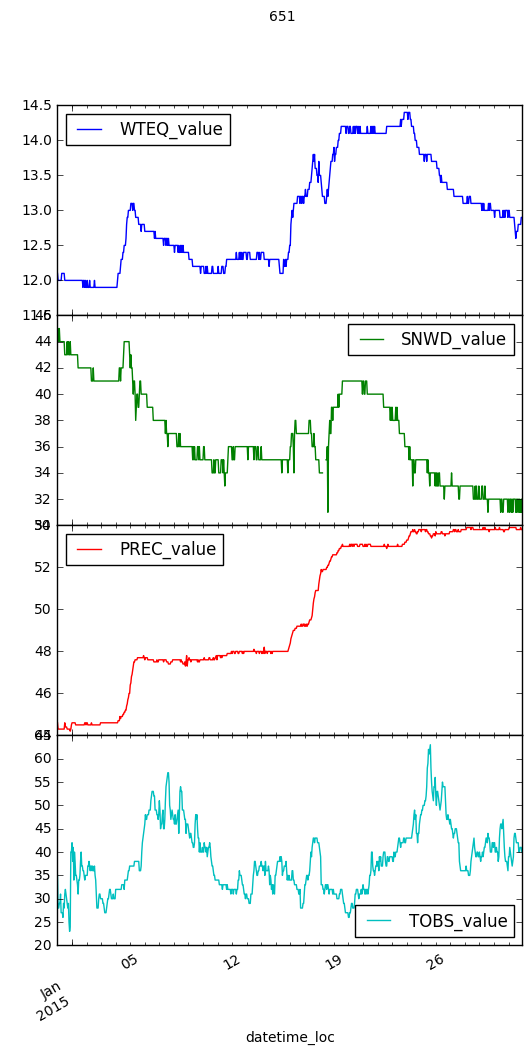

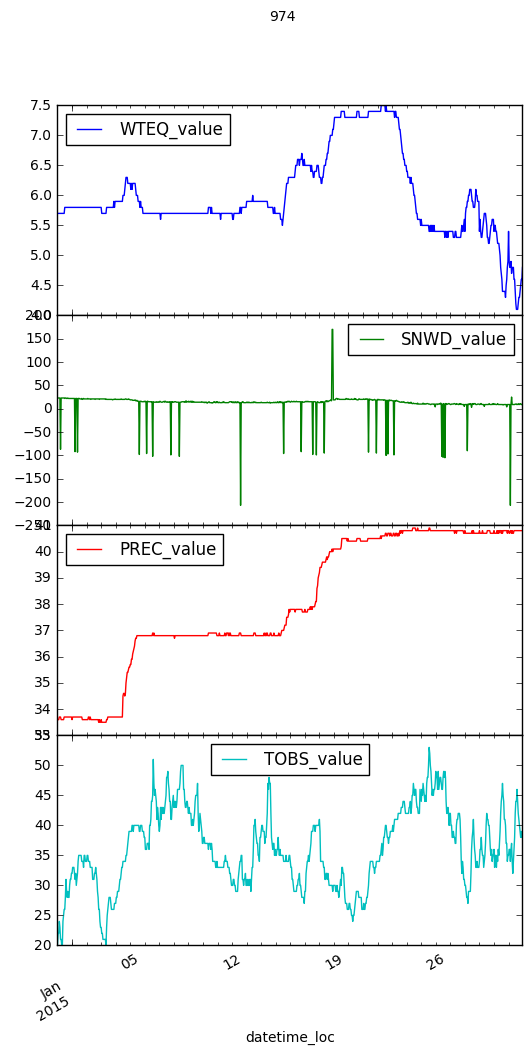

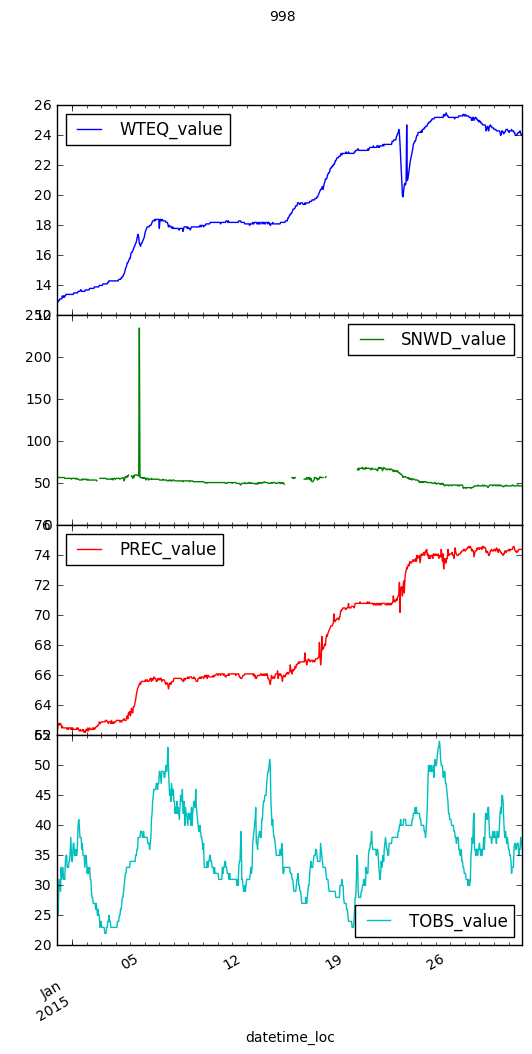

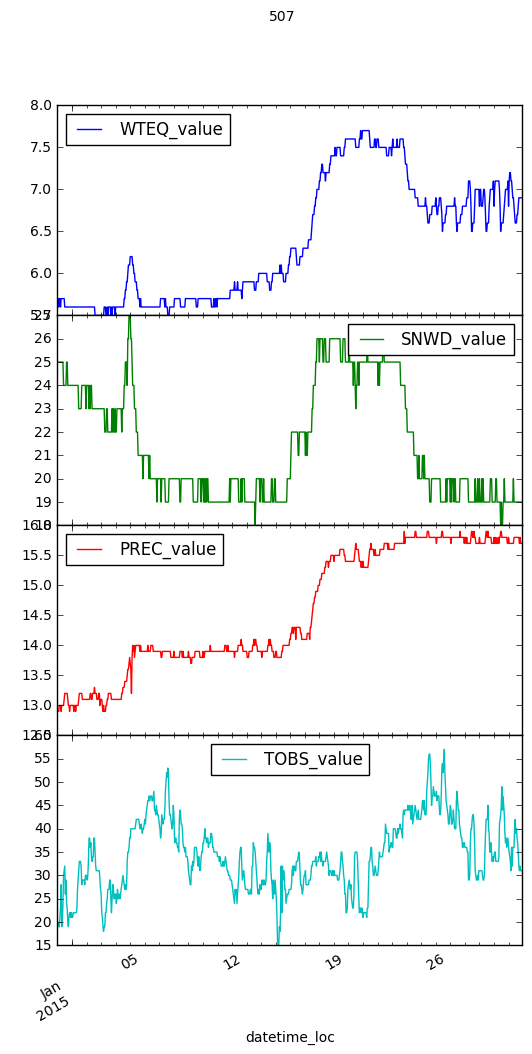

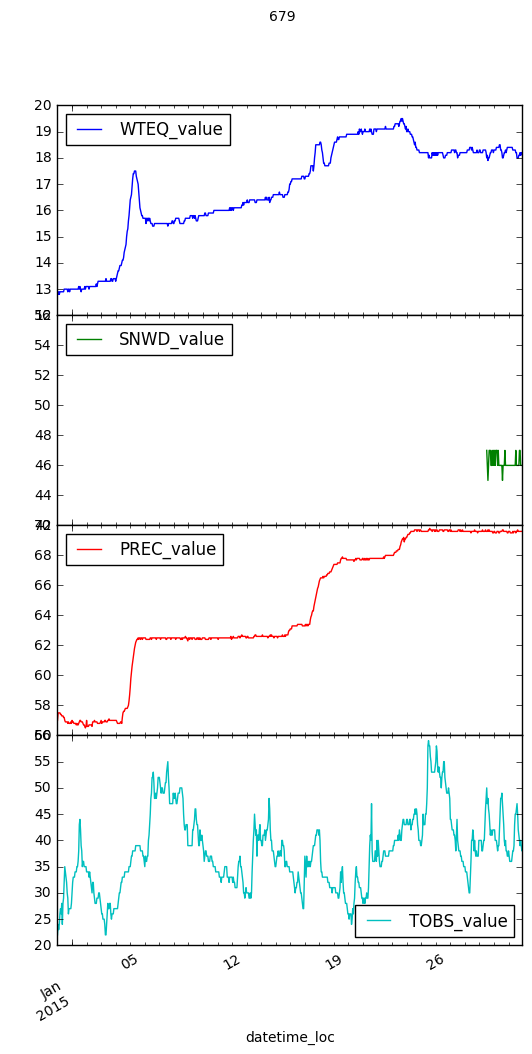

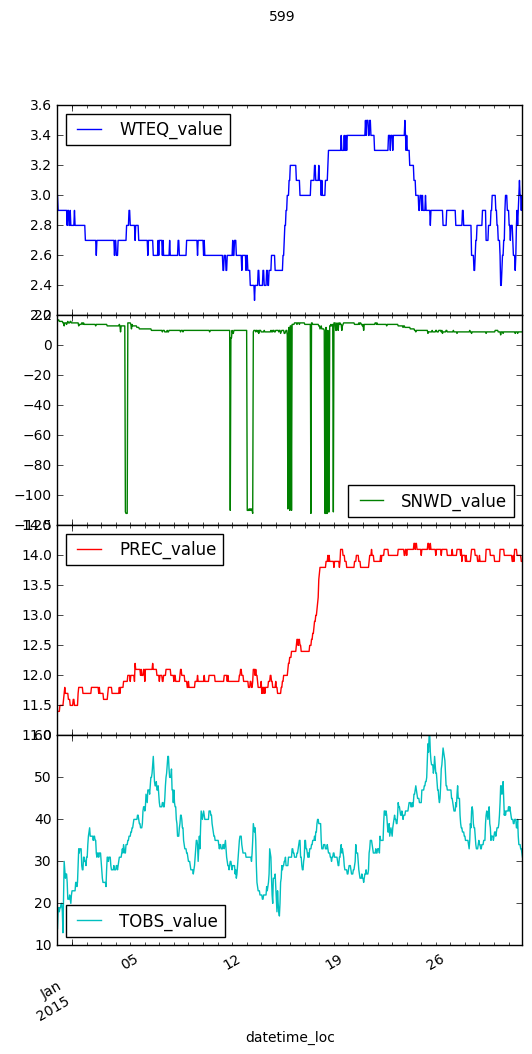

In [13]:
for site_id, df in dfs.groupby(level=0):
    plt.figure()
    df.index = df.index.droplevel(0)
    axes = df.plot(subplots=True, figsize=(6,12), legend=True)
    plt.subplots_adjust(hspace=0)
    plt.suptitle(site_id)
    #axes[-1].axhline(32, c='k', ls='--')

# NWAC ratings comparison



In [14]:
import sqlalchemy as sa

In [15]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [151]:
metadata = sa.MetaData()

forecast_table = sa.Table('forecasts', metadata,
                          sa.Column('forecast_id', sa.Integer,
                                    primary_key=True, autoincrement=False),
                          sa.Column('date', sa.Text),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.Time),
                          sa.Column('author', sa.Text),
                         )

report_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                          sa.Column('region', sa.Text),
                          sa.Column('summary', sa.Text),
                          sa.Column('treeline_above', sa.Text),
                          sa.Column('treeline_near', sa.Text),
                          sa.Column('treeline_below', sa.Text),
                        )

region_index = sa.Table('region_index', metadata,
                        sa.Column('forecast_id', sa.Integer, primary_key=True),
                        sa.Column('region', sa.Text, primary_key=True),
                        sa.Column('report_id', sa.Integer)
                       )

In [152]:
redistricting = [
    ('east-far-north',
     ['East Slopes North - Canadian Border to Lake Chelan', 'East slopes WA Cascades - north of Stevens Pass']),
    ('east-mid-north',
     ['East Slopes Central - Lake Chelan to South of I-90', 'East slopes WA Cascades - north of Stevens Pass']),
    ('east-central',
     ['East Slopes Central - Lake Chelan to South of I-90', 'East slopes WA Cascades - between Stevens and Snoqualmie Pass']),
    ('east-mid-south',
     ['East Slopes South - South of I-90 to Columbia River', 'East slopes WA Cascades - between Snoqualmie and White Pass']),
    ('east-far-south',
     ['East Slopes South - South of I-90 to Columbia River', 'East slopes WA Cascades - south of White Pass']),
    #deep breath
    ('west-far-north',
     ['West Slopes North - Canadian Border to Skagit River', 'WA Cascades near and west of crest - north of Stevens Pass']),
    ('west-mid-north',
     ['West Slopes Central - Skagit River to South of I-90', 'WA Cascades near and west of crest - north of Stevens Pass']),
    ('west-central',
     ['West Slopes Central - Skagit River to South of I-90', 'WA Cascades near and west of crest - between Stevens and Snoqualmie Pass']),
    ('west-mid-south',
     ['West Slopes South - South of I-90 to Columbia River', 'WA Cascades near and west of crest - between Snoqualmie and White Pass']),
    ('west-far-south',
     ['West Slopes South - South of I-90 to Columbia River', 'WA Cascades near and west of crest - south of White Pass']),
]

In [ ]:
def fetch_nwac_ratings(range_min, range_max, region='Mt Hood'):
    # this database uses utc
    stmt = sa.select([report_table]
                    ).where(
                        report_table.c.region == region
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)

    df2 = pd.read_sql_query(stmt, engine)
    df2 = df2.set_index('datetime_utc')
    return df2

In [178]:
list(report_table.columns)

[Column('report_id', Integer(), table=<reports>, primary_key=True, nullable=False),
 Column('datetime', Text(), table=<reports>),
 Column('datetime_utc', DateTime(), table=<reports>),
 Column('author', Text(), table=<reports>),
 Column('region', Text(), table=<reports>),
 Column('summary', Text(), table=<reports>),
 Column('treeline_above', Text(), table=<reports>),
 Column('treeline_near', Text(), table=<reports>),
 Column('treeline_below', Text(), table=<reports>)]

In [179]:
def fetch_nwac_ratings(range_min, range_max, region='Mt Hood'):
    # if a redistricted region was given,
    # get the list of regions to get ratings
    # from. otherwise it's just the argument
    regions = dict(redistricting).get(region, [region,])
    joined = region_index.join(report_table,
                           report_table.c.report_id == region_index.c.report_id)
    stmt = sa.select([report_table]
                ).select_from(
                        joined
                    ).where(
                        sa.or_(region_index.c.region == subr for subr in regions)
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)
    

    df2 = pd.read_sql_query(stmt, engine)
    df2['region'] = region  # overwrite 'report region' with region requested
    df2 = df2.set_index('datetime_utc')
    return df2

In [159]:
def fetch_nwac_ratings_localtime(range_min, range_max, region='Mt Hood'):
    # convert to utc
    utc_min,utc_max = (tzconvert(bound, pacific, pytz.utc) for bound in (range_min, range_max))
    # hit the database
    df2 = fetch_nwac_ratings(utc_min, utc_max, region=region)
    # reindex by local time
    df2['datetime_loc'] = df2.index.tz_localize(pytz.utc).tz_convert(pacific).tz_localize(None)
    df2 = df2.reset_index().set_index('datetime_loc')
    return df2

In [199]:
df2 = fetch_nwac_ratings(range_min, range_max, 'west-mid-north')
print(len(df2))
df2.head()

299


,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_utc,,,,,,,,
2014-01-07 01:32:00,232,"5:32 PM PST Monday, January 6, 2014",Dennis D'Amico,west-mid-north,The Bottom Line: New loading through this week...,Moderate,Moderate,Low
2014-01-08 02:00:00,235,"6:00 PM PST Tuesday, January 7, 2014",Dennis D'Amico,west-mid-north,The Bottom Line: Look for increasing avalanche...,Considerable,Moderate,Moderate
2014-01-09 02:00:00,243,"6:00 PM PST Wednesday, January 8, 2014",Kenny Kramer,west-mid-north,Bottom Line: Cooling should help new snow prof...,Considerable,Considerable,Moderate
2014-01-10 02:00:00,251,"6:00 PM PST Thursday, January 9, 2014",Garth Ferber,west-mid-north,"An active, complex weather pattern will cause ...",Considerable,Considerable,Moderate
2014-01-10 16:54:00,257,"8:54 AM PST Friday, January 10, 2014",Garth Ferber,west-mid-north,"An active, complex weather pattern will cause ...",High,Considerable,Moderate


In [181]:
df2 = fetch_nwac_ratings_localtime(range_min, range_max)
df2.head()

,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2014-01-05 18:00:00,2014-01-06 02:00:00,231,"6:00 PM PST Sunday, January 5, 2014",Garth Ferber,Mt Hood,NWAC avalanche forecasts apply to backcountry ...,Low,Low,Low
2014-01-06 17:32:00,2014-01-07 01:32:00,234,"5:32 PM PST Monday, January 6, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: If precipitation rates of the...,Moderate,Low,Low
2014-01-07 18:00:00,2014-01-08 02:00:00,237,"6:00 PM PST Tuesday, January 7, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: Look for increasing avalanche...,Moderate,Moderate,Moderate
2014-01-08 18:00:00,2014-01-09 02:00:00,246,"6:00 PM PST Wednesday, January 8, 2014",Kenny Kramer,Mt Hood,Bottom Line: Cooling should help new snow prof...,Considerable,Considerable,Moderate
2014-01-09 18:00:00,2014-01-10 02:00:00,255,"6:00 PM PST Thursday, January 9, 2014",Garth Ferber,Mt Hood,"An active, complex weather pattern will cause ...",Considerable,Considerable,Moderate


In [182]:
regions = ref['nwac_region']
frames = [fetch_nwac_ratings_localtime(range_min, range_max, region=region) for region in regions]
dfs2 = pd.concat(frames, keys=regions, names=['nwac_region',])
dfs2.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-01-05 18:00:00 2014-01-06 02:00:00        231   
            2014-01-06 17:32:00 2014-01-07 01:32:00        234   
            2014-01-07 18:00:00 2014-01-08 02:00:00        237   
            2014-01-08 18:00:00 2014-01-09 02:00:00        246   
            2014-01-09 18:00:00 2014-01-10 02:00:00        255   

                                                               datetime  \
nwac_region datetime_loc                                                  
Mt Hood     2014-01-05 18:00:00     6:00 PM PST Sunday, January 5, 2014   
            2014-01-06 17:32:00     5:32 PM PST Monday, January 6, 2014   
            2014-01-07 18:00:00    6:00 PM PST Tuesday, January 7, 2014   
            2014-01-08 18:00:00  6:00 PM PST Wednesday, January 8, 2014   
            2014-01-09 18:00:00   6:00 PM PST Thursday, January 9, 2014   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-01-05 18:00:00    Garth Ferber  Mt Hood   
            2014-01-06 17:32:00  Dennis D'Amico  Mt Hood   
            2014-01-07 18:00:00  Dennis D'Amico  Mt Hood   
            2014-01-08 18:00:00    Kenny Kramer  Mt Hood   
            2014-01-09 18:00:00    Garth Ferber  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-01-05 18:00:00  NWAC avalanche forecasts apply to backcountry ...   
            2014-01-06 17:32:00  The Bottom Line: If precipitation rates of the...   
            2014-01-07 18:00:00  The Bottom Line: Look for increasing avalanche...   
            2014-01-08 18:00:00  Bottom Line: Cooling should help new snow prof...   
            2014-01-09 18:00:00  An active, complex weather pattern will cause ...   

                                treeline_above treeline_near treeline_below  
nwac_region datetime_loc                                                     
Mt Hood     2014-01-05 18:00:00            Low           Low            Low  
            2014-01-06 17:32:00       Moderate           Low            Low  
            2014-01-07 18:00:00       Moderate      Moderate       Moderate  
            2014-01-08 18:00:00   Considerable  Considerable       Moderate  
            2014-01-09 18:00:00   Considerable  Considerable       Moderate

In [183]:
len(dfs2)

1795

In [184]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [185]:
# convert to a numerical rating
ratdict = {rat:i for i,rat in enumerate(ratings)}

ratings_to_numbers = {'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}

dfsn = dfs2.replace(ratings_to_numbers)
dfsn.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-01-05 18:00:00 2014-01-06 02:00:00        231   
            2014-01-06 17:32:00 2014-01-07 01:32:00        234   
            2014-01-07 18:00:00 2014-01-08 02:00:00        237   
            2014-01-08 18:00:00 2014-01-09 02:00:00        246   
            2014-01-09 18:00:00 2014-01-10 02:00:00        255   

                                                               datetime  \
nwac_region datetime_loc                                                  
Mt Hood     2014-01-05 18:00:00     6:00 PM PST Sunday, January 5, 2014   
            2014-01-06 17:32:00     5:32 PM PST Monday, January 6, 2014   
            2014-01-07 18:00:00    6:00 PM PST Tuesday, January 7, 2014   
            2014-01-08 18:00:00  6:00 PM PST Wednesday, January 8, 2014   
            2014-01-09 18:00:00   6:00 PM PST Thursday, January 9, 2014   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-01-05 18:00:00    Garth Ferber  Mt Hood   
            2014-01-06 17:32:00  Dennis D'Amico  Mt Hood   
            2014-01-07 18:00:00  Dennis D'Amico  Mt Hood   
            2014-01-08 18:00:00    Kenny Kramer  Mt Hood   
            2014-01-09 18:00:00    Garth Ferber  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-01-05 18:00:00  NWAC avalanche forecasts apply to backcountry ...   
            2014-01-06 17:32:00  The Bottom Line: If precipitation rates of the...   
            2014-01-07 18:00:00  The Bottom Line: Look for increasing avalanche...   
            2014-01-08 18:00:00  Bottom Line: Cooling should help new snow prof...   
            2014-01-09 18:00:00  An active, complex weather pattern will cause ...   

                                 treeline_above  treeline_near  treeline_below  
nwac_region datetime_loc                                                        
Mt Hood     2014-01-05 18:00:00               1              1               1  
            2014-01-06 17:32:00               2              1               1  
            2014-01-07 18:00:00               2              2               2  
            2014-01-08 18:00:00               3              3               2  
            2014-01-09 18:00:00               3              3               2

In [186]:
len(dfsn)

1795

join to get site id column

In [187]:
dfsm = pd.merge(dfsn.reset_index(), ref[['nwac_region', 'elev',]].reset_index(),
                on='nwac_region', how='left').set_index(['nwac_region', 'datetime_loc'])
dfsm.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-01-05 18:00:00 2014-01-06 02:00:00        231   
            2014-01-06 17:32:00 2014-01-07 01:32:00        234   
            2014-01-07 18:00:00 2014-01-08 02:00:00        237   
            2014-01-08 18:00:00 2014-01-09 02:00:00        246   
            2014-01-09 18:00:00 2014-01-10 02:00:00        255   

                                                               datetime  \
nwac_region datetime_loc                                                  
Mt Hood     2014-01-05 18:00:00     6:00 PM PST Sunday, January 5, 2014   
            2014-01-06 17:32:00     5:32 PM PST Monday, January 6, 2014   
            2014-01-07 18:00:00    6:00 PM PST Tuesday, January 7, 2014   
            2014-01-08 18:00:00  6:00 PM PST Wednesday, January 8, 2014   
            2014-01-09 18:00:00   6:00 PM PST Thursday, January 9, 2014   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-01-05 18:00:00    Garth Ferber  Mt Hood   
            2014-01-06 17:32:00  Dennis D'Amico  Mt Hood   
            2014-01-07 18:00:00  Dennis D'Amico  Mt Hood   
            2014-01-08 18:00:00    Kenny Kramer  Mt Hood   
            2014-01-09 18:00:00    Garth Ferber  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-01-05 18:00:00  NWAC avalanche forecasts apply to backcountry ...   
            2014-01-06 17:32:00  The Bottom Line: If precipitation rates of the...   
            2014-01-07 18:00:00  The Bottom Line: Look for increasing avalanche...   
            2014-01-08 18:00:00  Bottom Line: Cooling should help new snow prof...   
            2014-01-09 18:00:00  An active, complex weather pattern will cause ...   

                                 treeline_above  treeline_near  \
nwac_region datetime_loc                                         
Mt Hood     2014-01-05 18:00:00               1              1   
            2014-01-06 17:32:00               2              1   
            2014-01-07 18:00:00               2              2   
            2014-01-08 18:00:00               3              3   
            2014-01-09 18:00:00               3              3   

                                 treeline_below  site_id  elev  
nwac_region datetime_loc                                        
Mt Hood     2014-01-05 18:00:00               1      651  5370  
            2014-01-06 17:32:00               1      651  5370  
            2014-01-07 18:00:00               2      651  5370  
            2014-01-08 18:00:00               2      651  5370  
            2014-01-09 18:00:00               2      651  5370

In [195]:
dfsr = dfsm.unstack(level=0)
#.resample('1H', fill_method='pad')
#.stack()
#.reset_index()
#.set_index(hier)
dfsr.head()

ValueError: Index contains duplicate entries, cannot reshape

what the hell? the index is doch unique

In [240]:
dfsm.index.levels[0]

Index(['Mt Hood', 'Olympics', 'east-central', 'east-far-south',
       'west-far-north', 'west-mid-south'],
      dtype='object', name='nwac_region')

In [241]:
dfsm.index.levels[0].is_unique

True

In [242]:
dfsm.index.levels[1].is_unique

True

In [243]:
dfsm.index.is_unique

False

no idea what's going on here

resample by the hour

In [259]:
def resample_chunk(chunk):
    return chunk.resample('1H', fill_method='pad').reset_index(
                        ).set_index(['site_id', 'datetime_loc'])

chunks = [resample_chunk(dfsm.ix[reg]) for reg in regions]
dfsr = pd.concat(chunks, keys=regions, names=['nwac_region',])
dfsr.head()

report_id  treeline_above  \
nwac_region site_id datetime_loc                                     
Mt Hood     651     2014-01-05 18:00:00        231               1   
                    2014-01-05 19:00:00        231               1   
                    2014-01-05 20:00:00        231               1   
                    2014-01-05 21:00:00        231               1   
                    2014-01-05 22:00:00        231               1   

                                         treeline_near  treeline_below  elev  
nwac_region site_id datetime_loc                                              
Mt Hood     651     2014-01-05 18:00:00              1               1  5370  
                    2014-01-05 19:00:00              1               1  5370  
                    2014-01-05 20:00:00              1               1  5370  
                    2014-01-05 21:00:00              1               1  5370  
                    2014-01-05 22:00:00              1               1  5370

In [ ]:
hier = ['nwac_region', 'site_id', 'datetime_loc']

In [ ]:
dfsr = dfsmwtf.unstack('nwac_region')
#.resample('1H', fill_method='pad')
#.stack()
#.reset_index()
#.set_index(hier)
dfsr.head()

In [260]:
len(dfsr)

76907

In [261]:
dfsr.columns

Index(['report_id', 'treeline_above', 'treeline_near', 'treeline_below',
       'elev'],
      dtype='object')

merge with snotel data

In [262]:
len(dfs)

4608

In [263]:
dfs.columns

Index(['Date', 'WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value',
       'datetime_utc'],
      dtype='object')

In [264]:
dfs.index.names

FrozenList(['site_id', 'datetime_loc'])

In [265]:
dfsa = pd.merge(dfsr.reset_index(), dfs.reset_index(),
                on=hier[1:],  # not nwac_region, dfs doesn't have that
                ).set_index(hier)
dfsa.head()

report_id  treeline_above  \
nwac_region site_id datetime_loc                                     
Mt Hood     651     2014-12-31 00:00:00        988               3   
                    2014-12-31 01:00:00        988               3   
                    2014-12-31 02:00:00        988               3   
                    2014-12-31 03:00:00        988               3   
                    2014-12-31 04:00:00        988               3   

                                         treeline_near  treeline_below  elev  \
nwac_region site_id datetime_loc                                               
Mt Hood     651     2014-12-31 00:00:00              2               2  5370   
                    2014-12-31 01:00:00              2               2  5370   
                    2014-12-31 02:00:00              2               2  5370   
                    2014-12-31 03:00:00              2               2  5370   
                    2014-12-31 04:00:00              2               2  5370   

                                                     Date  WTEQ_value  \
nwac_region site_id datetime_loc                                        
Mt Hood     651     2014-12-31 00:00:00  2014-12-31 00:00        12.1   
                    2014-12-31 01:00:00  2014-12-31 01:00        12.0   
                    2014-12-31 02:00:00  2014-12-31 02:00        12.0   
                    2014-12-31 03:00:00  2014-12-31 03:00        12.0   
                    2014-12-31 04:00:00  2014-12-31 04:00        12.0   

                                         SNWD_value  PREC_value  TOBS_value  \
nwac_region site_id datetime_loc                                              
Mt Hood     651     2014-12-31 00:00:00          44        44.6          35   
                    2014-12-31 01:00:00          45        44.3          28   
                    2014-12-31 02:00:00          44        44.3          28   
                    2014-12-31 03:00:00          45        44.3          29   
                    2014-12-31 04:00:00          44        44.3          29   

                                               datetime_utc  
nwac_region site_id datetime_loc                             
Mt Hood     651     2014-12-31 00:00:00 2014-12-31 08:00:00  
                    2014-12-31 01:00:00 2014-12-31 09:00:00  
                    2014-12-31 02:00:00 2014-12-31 10:00:00  
                    2014-12-31 03:00:00 2014-12-31 11:00:00  
                    2014-12-31 04:00:00 2014-12-31 12:00:00

In [266]:
dfsa.columns

Index(['report_id', 'treeline_above', 'treeline_near', 'treeline_below',
       'elev', 'Date', 'WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value',
       'datetime_utc'],
      dtype='object')

In [267]:
len(dfsa)

4608

In [268]:
dfs.columns

Index(['Date', 'WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value',
       'datetime_utc'],
      dtype='object')

In [269]:
plotcols = ['WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value', 'treeline_above']

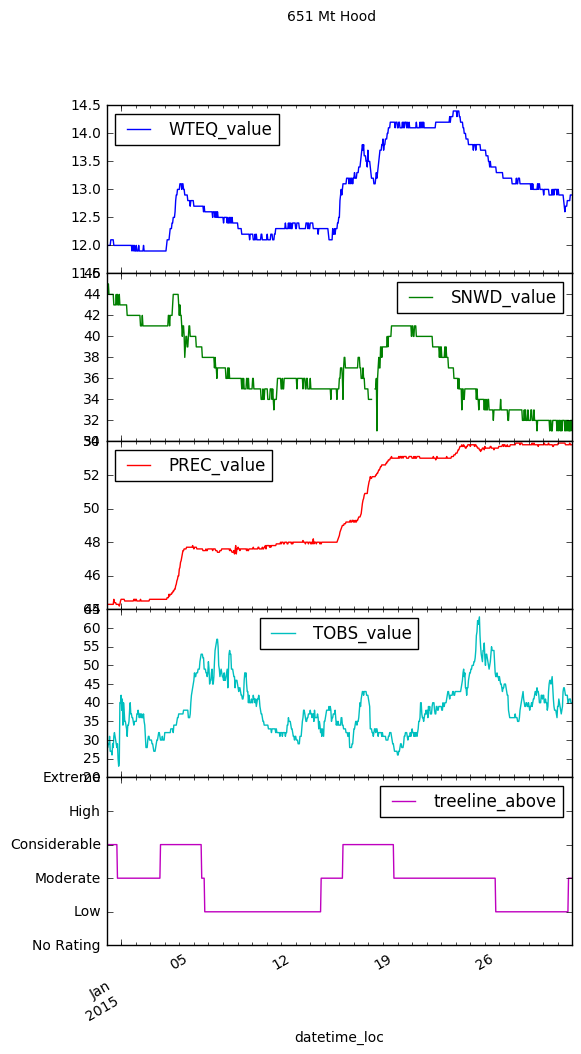

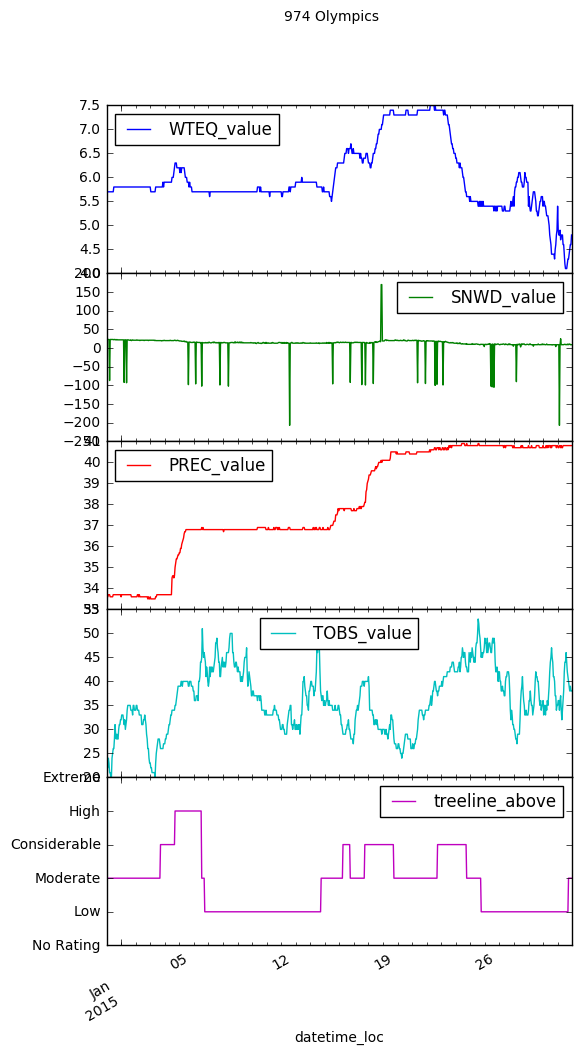

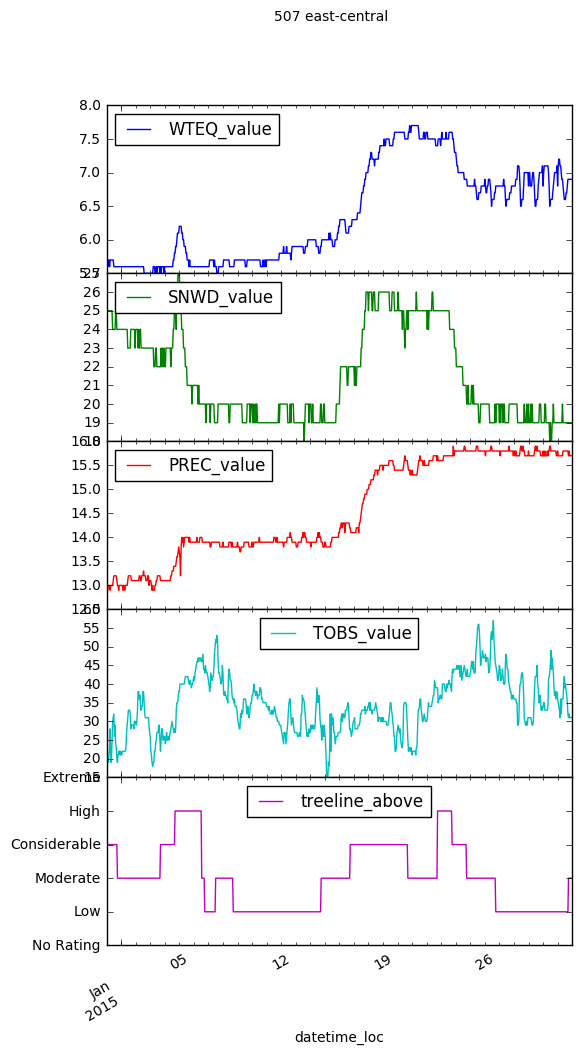

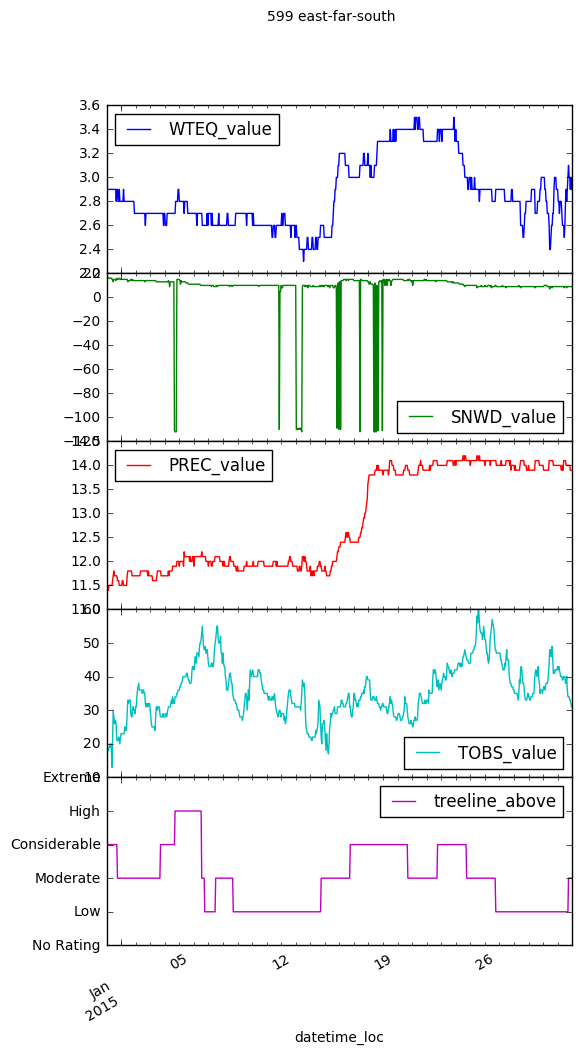

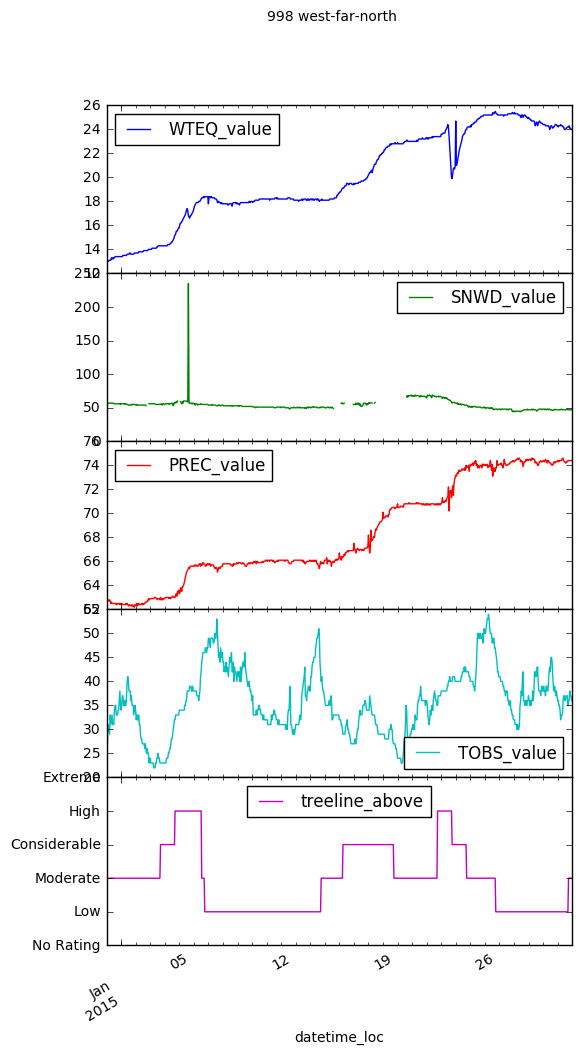

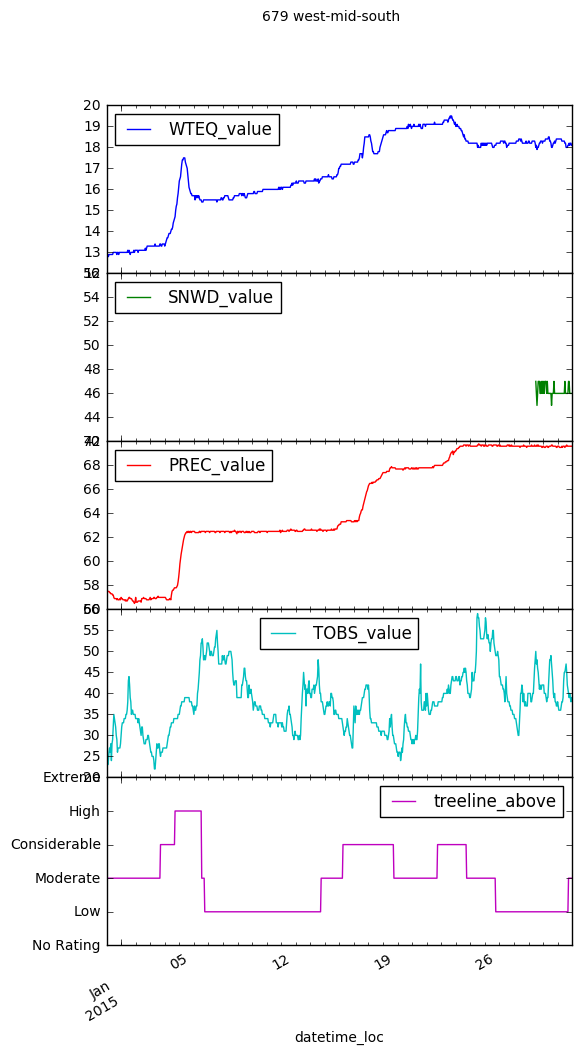

In [270]:
for (region,site_id),dfx in dfsa.groupby(level=[0,1]):
    
    plt.figure()
    
    
    dfx.index = dfx.index.droplevel(0).droplevel(0)
    dfx = dfx[plotcols]
    
    
    axes = dfx.plot(subplots=True, figsize=(6,12), legend=True)
    plt.subplots_adjust(hspace=0)
    plt.suptitle('%d %s' % (site_id,region))

    #axes[-2].axhline(32, c='k', ls='--')
    axes[-1].set_ylim(-0,5);
    axes[-1].set_yticklabels(ratings)
    #axes[-1].lines[0].set_marker('o')

    #plt.savefig('jan2015.pdf')
#dfx

# Daily binning

feature engineering: make this into scatter plots

In [271]:
def make_engineered_features(usda_df, nwac_usda_df):
    
    features = {
        'treeline_above': nwac_usda_df.replace(ratings_to_numbers)['treeline_above'].resample('1D', how='last'),
        'precip_today': usda_df['Precipitation Accumulation (in)'].resample('1D').diff(),
        'snowdep':      usda_df['Snow Depth (in)'].resample('1D'),
        'watereq':      usda_df['Snow Water Equivalent (in)'].resample('1D'),
        'avgtemp':      usda_df['Air Temperature Observed (degF)'].resample('1D'),
    }
    
    features['tempchange'] = features['avgtemp'].diff()
    # pseudo-density: don't divide by zero
    features['density'] = features['watereq'] / (features['snowdep'] + 1)

    engineered = pd.DataFrame(features)

    return engineered


In [272]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}

numdict = {i:color for i, color in enumerate(colors)}
labdict = {i:rating for i, rating in enumerate(ratings)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [273]:
def plot_classes(engineered, x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    for val,subdf in engineered.groupby('treeline_above'):
        subdf.plot(kind='scatter',
                    x=x, y=y,
                    c=numdict.get(val, 'm'),
                    label=labdict.get(val, val),
                    ax=ax)
    ax.legend(loc='upper left', ncol=2)
 

binning by the day is probably a bad approach. for each avalanche report, we should construct a time window extending 24 hours (or whatever) back in time from the date the report was issued. This would avoid sampling future data, and also avoid 2 reports on the same day getting their numerical values averaged

TODO!

# try daily data

In [274]:
range_min,range_max = pd.datetime(2013,11,1), pd.datetime(2015,8,1)

In [275]:
range_mid = pd.datetime(2015,3,1)

In [276]:
%%writefile snotelier/usda_daily.py

import numpy as np
import requests
import pandas as pd
import io

def p2f(x):
    try:
        val = float(x.strip('%'))
    except ValueError:
        val = np.nan
    return val

def get_usda_daily(site, range_min, range_max, state='WA'):
    # all USDA times are LOCAL TIME (PDT/PST)

    cols = [
        ('WTEQ','value'),
        ('WTEQ','pctOfMedian_1981'),
        ('SNWD','value'),
        ('PREC','value'),
        ('PREC','pctOfMedian_1981'),
        ('TMAX','value'),
        ('TMIN','value'),
        ('TAVG','value'),
        ]

    colstring = ','.join('{}::{}'.format(name,avg) for name,avg in cols)
    coltitles = ['Date',] + list('{}_{}'.format(name,avg) for name,avg in cols)
    
    converters = {'Snow Water Equivalent % of Median (1981-2010)': p2f,
                  'Precipitation Accumulation % of Median (1981-2010)': p2f}

    fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
           'customSingleStationReport/daily/{site}:{state}:SNTL/{range_min},{range_max}/{columns}')

    # convert these to strings.
    # the bound granularity is only by day, not by hour.
    range_min, range_max = (bound.strftime('%Y-%m-%d')
                            for bound in (range_min, range_max))

    url = fmt.format(range_min=range_min,
                     range_max=range_max,
                     columns=colstring, site=site, state=state)
    
    r = requests.get(url)

    # parse dataframe
    df = pd.read_csv(io.StringIO(r.text), comment='#',
                    converters=converters)
    
    # shorten column labels
    collabels = df.columns
    df.columns = coltitles
    
    # cheat sheet for column labels
    for a,b in zip(coltitles,collabels):
        pass
        #print("{}:{}".format(a,b))

    # as far as I can tell, dates are in pacific time. No idea whether DST is accounted for
    df['datetime_loc'] = pd.to_datetime(df['Date'])
    #df['date_utc'] = pd.to_datetime(df['Date'] + ' PST')
    df = df.set_index('datetime_loc').drop('Date', axis=1)
    return df #, collabels, url


Overwriting snotelier/usda_daily.py


In [277]:
%run snotelier/usda_daily.py

always do NEWEST LAST!

In [278]:
df = get_usda_daily(651, range_min, range_mid, state='OR')
df.tail()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,
2015-02-25,13.2,28,31,59.2,88,36,30,32
2015-02-26,13.5,29,32,59.5,88,35,32,33
2015-02-27,14.2,30,33,60.2,88,38,28,32
2015-02-28,14.8,31,37,60.8,89,34,25,28
2015-03-01,14.7,31,37,60.9,89,42,25,32


In [279]:
df['SNWD_value'].tail().diff(1)

datetime_loc
2015-02-25   NaN
2015-02-26     1
2015-02-27     1
2015-02-28     4
2015-03-01     0
Name: SNWD_value, dtype: float64

when we do diff, use positive numbers. here we se positive numbers because snow is getting deeper.

sometimes USDA website goes down so make a cache of stuff

In [280]:
daily_table = sa.Table('usda_daily', metadata,
                        sa.Column('site_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime_loc', sa.Date,
                                  primary_key=True, autoincrement=False),
                          sa.Column('WTEQ_value', sa.Float),
                          sa.Column('WTEQ_pctOfMedian_1981', sa.Float),
                          sa.Column('SNWD_value', sa.Float),
                          sa.Column('PREC_value', sa.Float),
                          sa.Column('PREC_pctOfMedian_1981', sa.Float),
                          sa.Column('TMAX_value', sa.Float),
                          sa.Column('TMIN_value', sa.Float),
                          sa.Column('TAVG_value', sa.Float),
                        )

In [281]:
#daily_table.create(engine)

df.to_sql(con=con, name='tablename_temp', if_exists='replace')
connection = con.connect()
connection.execute(text("""INSERT INTO tablename SELECT * FROM tablename_temp
                        ON DUPLICATE KEY UPDATE tablename.field_to_update=tablename_temp.field_to_update"""))
connection.execute(text('DROP TABLE tablename_temp '))

In [282]:
def store_usda_daily(df, site_id):
    dfins = df.copy()
    dfins['site_id'] = site_id
    dfins.to_sql('usda_daily', engine, if_exists='append')

In [286]:
def scrape_usda_daily(range_min, range_max, site_id):
    # scrape the data
    state = ref['state'].ix[site_id]
    df = get_usda_daily(site_id, range_min, range_max, state=state)
    # store it
    store_usda_daily(df, site_id)

In [287]:
ref.index

Int64Index([651, 974, 998, 507, 679, 599], dtype='int64', name='site_id')

In [ ]:
scrape_usda_daily(range_min, range_max, 599)

In [288]:
def fetch_usda_daily(range_min, range_max, site_id):
    # this database uses local time
    stmt = sa.select([daily_table]
                    ).where(
                        daily_table.c.site_id == site_id
                    ).where(
                        daily_table.c.datetime_loc <= range_max
                    ).where(
                        daily_table.c.datetime_loc >= range_min
                    ).order_by(daily_table.c.datetime_loc)

    df2 = pd.read_sql_query(stmt, engine)
    df2['datetime_loc'] = pd.to_datetime(df2['datetime_loc'])
    df2 = df2.set_index('datetime_loc') #.sort_index(ascending=False)
    return df2

In [289]:
dfdb = fetch_usda_daily(range_min, range_mid, 651)
dfdb.tail()

,site_id,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,,
2015-02-25,651,13.2,28,31,59.2,88,36,30,32
2015-02-26,651,13.5,29,32,59.5,88,35,32,33
2015-02-27,651,14.2,30,33,60.2,88,38,28,32
2015-02-28,651,14.8,31,37,60.8,89,34,25,28
2015-03-01,651,14.7,31,37,60.9,89,42,25,32


In [290]:
dfdb = fetch_usda_daily(range_min, range_mid, 974)
dfdb.tail()

,site_id,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,,
2015-02-25,974,0.0,0,0,49.3,89,37,30,33
2015-02-26,974,0.1,0,1,49.4,89,40,33,35
2015-02-27,974,0.4,1,6,49.7,89,33,26,31
2015-02-28,974,1.3,4,9,50.5,91,33,21,24
2015-03-01,974,1.3,4,9,50.5,90,36,22,28


In [291]:
def data_for_site(site_id):
    # shortcut that uses globals for state and range bounds
    state = ref['state'].ix[site_id]
    df = get_usda_daily(site_id, range_min, range_max, state=state)
    return df

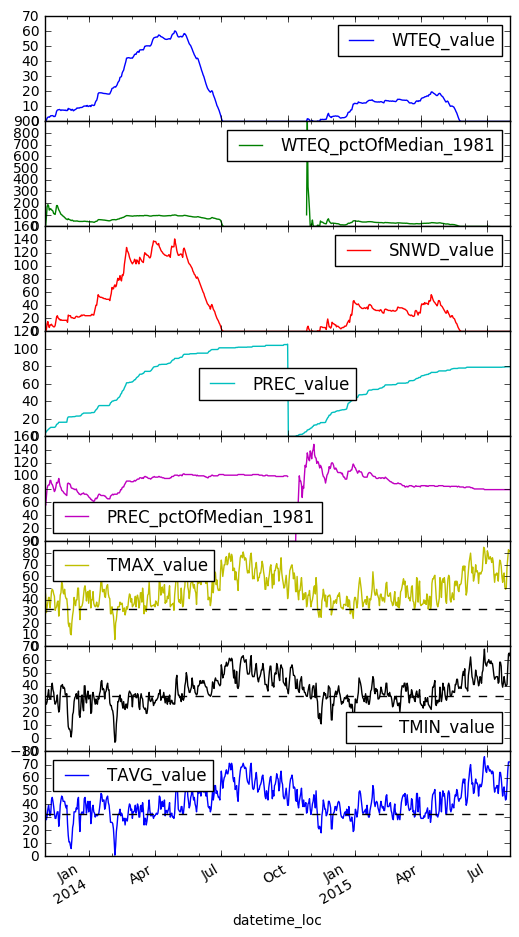

In [292]:
df = data_for_site(651)

axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
for ax in axes[-3:]:
    ax.axhline(32, c='k', ls='--')

# now incorporate nwac data

In [293]:
dffml = fetch_nwac_ratings_localtime(range_min, range_max, region='Mt Hood')
dffml.tail()

,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2015-04-20 10:53:00,2015-04-20 17:53:00,1605,"10:53 AM PST Monday, April 20, 2015",Dennis D'Amico,Mt Hood,The last daily NWAC forecasts for this season ...,None,None,None
2015-04-24 18:00:00,2015-04-25 01:00:00,1614,"6:00 PM PST Friday, April 24, 2015",Garth Ferber,Mt Hood,Don't underestimate the effects of the increas...,Considerable,Moderate,Low
2015-04-25 18:00:00,2015-04-26 01:00:00,1619,"6:00 PM PST Saturday, April 25, 2015",Kenny Kramer,Mt Hood,Don't underestimate the effects of the strong ...,Moderate,Moderate,Low
2015-04-27 09:11:00,2015-04-27 16:11:00,1620,"9:11 AM PST Monday, April 27, 2015",Kenny Kramer,Mt Hood,The last daily NWAC forecasts for this season ...,None,None,None
2015-06-24 14:14:00,2015-06-24 21:14:00,1625,"2:14 PM PST Wednesday, June 24, 2015",Dennis D'Amico,Mt Hood,NWAC avalanche forecasts apply to backcountry ...,None,None,None


In [294]:
nwac_areas = ['treeline_%s' % s for s in ('above', 'near', 'below')]

In [295]:
dfomg = dffml.replace(ratings_to_numbers)[nwac_areas]
dfomg.tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-04-20 10:53:00,NaN,NaN,NaN
2015-04-24 18:00:00,3,2,1
2015-04-25 18:00:00,2,2,1
2015-04-27 09:11:00,NaN,NaN,NaN
2015-06-24 14:14:00,NaN,NaN,NaN


In [296]:
dfomg.resample('1D').tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-06-20,NaN,NaN,NaN
2015-06-21,NaN,NaN,NaN
2015-06-22,NaN,NaN,NaN
2015-06-23,NaN,NaN,NaN
2015-06-24,NaN,NaN,NaN


note that last one, 3,3,2, was a couple days ago

In [297]:
dfomg.resample('1D', how='last').tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-06-20,NaN,NaN,NaN
2015-06-21,NaN,NaN,NaN
2015-06-22,NaN,NaN,NaN
2015-06-23,NaN,NaN,NaN
2015-06-24,NaN,NaN,NaN


'last' prevents averaging during downsampling but doesn't halp us upsample

In [298]:
dfomg.resample('1D', how='last', fill_method='ffill', limit=7).tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-06-20,NaN,NaN,NaN
2015-06-21,NaN,NaN,NaN
2015-06-22,NaN,NaN,NaN
2015-06-23,NaN,NaN,NaN
2015-06-24,NaN,NaN,NaN


Forward fill does it, don't persist any report for more than 7 days

In [299]:
def resample_nwac_data(dffml):
    """ converts to numbers too """
    dfomg = dffml.replace(ratings_to_numbers)[nwac_areas]
    nwac_resampled = dfomg.resample('1D', how='last', fill_method='ffill', limit=7)
    return nwac_resampled

In [300]:
dfwtf = resample_nwac_data(dffml)
dfwtf.tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-06-20,NaN,NaN,NaN
2015-06-21,NaN,NaN,NaN
2015-06-22,NaN,NaN,NaN
2015-06-23,NaN,NaN,NaN
2015-06-24,NaN,NaN,NaN


In [301]:
df.tail()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,
2015-07-28,0,NaN,0,79.6,79,68,41,55
2015-07-29,0,NaN,0,79.6,79,75,54,65
2015-07-30,0,NaN,0,79.6,79,83,64,72
2015-07-31,0,NaN,0,79.6,79,81,65,72
2015-08-01,0,NaN,0,79.6,79,82,63,72


In [302]:
pd.concat([df, dfwtf], axis=1)[['SNWD_value', 'treeline_above']].head()

,SNWD_value,treeline_above
datetime_loc,,
2013-11-01,0,NaN
2013-11-02,0,NaN
2013-11-03,3,NaN
2013-11-04,12,NaN
2013-11-05,15,NaN


In [303]:
def incorporate_nwac_data(df, site_id):
    #look up the relevant nwac region
    region = ref['nwac_region'].ix[site_id]
    #query db for ratings from that region
    dffml = fetch_nwac_ratings_localtime(range_min, range_max, region=region)
    # graft it on
    nwac_resampled = resample_nwac_data(dffml)
    #return df, nwac_resampled
    df_result = pd.concat([df, nwac_resampled], axis=1)
    return df_result

In [304]:
df.tail()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,
2015-07-28,0,NaN,0,79.6,79,68,41,55
2015-07-29,0,NaN,0,79.6,79,75,54,65
2015-07-30,0,NaN,0,79.6,79,83,64,72
2015-07-31,0,NaN,0,79.6,79,81,65,72
2015-08-01,0,NaN,0,79.6,79,82,63,72


In [305]:
df.columns

Index(['WTEQ_value', 'WTEQ_pctOfMedian_1981', 'SNWD_value', 'PREC_value',
       'PREC_pctOfMedian_1981', 'TMAX_value', 'TMIN_value', 'TAVG_value'],
      dtype='object')

In [306]:
dffml = incorporate_nwac_data(df, 651)
dffml.tail()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,,,
2015-07-28,0,NaN,0,79.6,79,68,41,55,NaN,NaN,NaN
2015-07-29,0,NaN,0,79.6,79,75,54,65,NaN,NaN,NaN
2015-07-30,0,NaN,0,79.6,79,83,64,72,NaN,NaN,NaN
2015-07-31,0,NaN,0,79.6,79,81,65,72,NaN,NaN,NaN
2015-08-01,0,NaN,0,79.6,79,82,63,72,NaN,NaN,NaN


In [307]:
dffml[nwac_areas].tail()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2015-07-28,NaN,NaN,NaN
2015-07-29,NaN,NaN,NaN
2015-07-30,NaN,NaN,NaN
2015-07-31,NaN,NaN,NaN
2015-08-01,NaN,NaN,NaN


In [308]:
df.columns

Index(['WTEQ_value', 'WTEQ_pctOfMedian_1981', 'SNWD_value', 'PREC_value',
       'PREC_pctOfMedian_1981', 'TMAX_value', 'TMIN_value', 'TAVG_value'],
      dtype='object')

In [309]:
dffml.head()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,,,
2013-11-01,0.2,20,0,4.3,60,49,33,41,NaN,NaN,NaN
2013-11-02,0.1,10,0,4.3,55,44,27,33,NaN,NaN,NaN
2013-11-03,0.9,82,3,5.6,69,29,26,28,NaN,NaN,NaN
2013-11-04,2.2,169,12,6.7,81,34,28,31,NaN,NaN,NaN
2013-11-05,2.8,187,15,7.4,85,38,33,36,NaN,NaN,NaN


In [310]:
dffml[nwac_areas].head()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2013-11-01,NaN,NaN,NaN
2013-11-02,NaN,NaN,NaN
2013-11-03,NaN,NaN,NaN
2013-11-04,NaN,NaN,NaN
2013-11-05,NaN,NaN,NaN


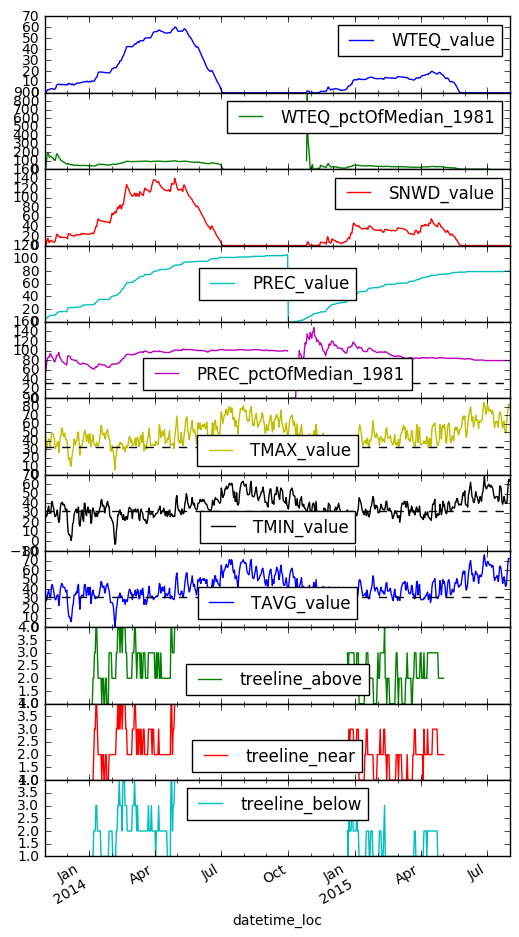

In [311]:
axes = dffml.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
for ax in axes[-7:-3]:
    ax.axhline(32, c='k', ls='--')

# Making engineered features (daily data)

 - all present day values (except precip)
 - precip since yesterday
 - yesterday's temp trends
 - precip since 2 days ago
 - temp trends from 2 days ago
 - change in snow depth since yesterday
 
we need to do this *before* we adjoint the NWAC ratings

In [312]:
df = data_for_site(651)
df.head()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,
2013-11-01,0.2,20,0,4.3,60,49,33,41
2013-11-02,0.1,10,0,4.3,55,44,27,33
2013-11-03,0.9,82,3,5.6,69,29,26,28
2013-11-04,2.2,169,12,6.7,81,34,28,31
2013-11-05,2.8,187,15,7.4,85,38,33,36


In [313]:
df.columns

Index(['WTEQ_value', 'WTEQ_pctOfMedian_1981', 'SNWD_value', 'PREC_value',
       'PREC_pctOfMedian_1981', 'TMAX_value', 'TMIN_value', 'TAVG_value'],
      dtype='object')

In [314]:
len(df)

639

In [315]:
%%writefile snotelier/engineered_daily.py

def make_engineered_daily(df):
    temps = ['TMAX_value', 'TMIN_value', 'TAVG_value',]

    current = temps + [
        #'SNWD_value', 'WTEQ_value',
        #'PREC_pctOfMedian_1981', #'WTEQ_pctOfMedian_1981'
    ]

    dfe = df[current]

    #these throw a bunch of warnings but I think it's ok
    dfe['TAVG_yest'] = df['TAVG_value'].shift(1) # avg temp yesterday
    dfe['SNWD_1day'] = df['SNWD_value'].diff(1) # 1 day snow depth diff
    dfe['SNWD_3day'] = df['SNWD_value'].diff(3) # 3 day snow depth diff
    dfe['PREC_1day'] = df['PREC_value'].diff(1) # 1 day precip diff

    return dfe

Overwriting snotelier/engineered_daily.py


In [316]:
%run snotelier/engineered_daily.py

In [317]:
dfe = make_engineered_daily(df)
print(len(dfe))
dfe.tail()

/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['TAVG_yest'] = df['TAVG_value'].shift(1) # avg temp yesterday
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['SNWD_1day'] = df['SNWD_value'].diff(1) # 1 day snow depth diff
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

639


,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,
2015-07-28,68,41,55,44,0,0,0
2015-07-29,75,54,65,55,0,0,0
2015-07-30,83,64,72,65,0,0,0
2015-07-31,81,65,72,72,0,0,0
2015-08-01,82,63,72,72,0,0,0


Note: these are newest-last.

now, get equivalent range of ratings from nwac and make an 'adjoint' data frame

In [318]:
df2 = fetch_nwac_ratings_localtime(range_min, range_max)
print(len(df2))
df2.head()

300


,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2014-01-05 18:00:00,2014-01-06 02:00:00,231,"6:00 PM PST Sunday, January 5, 2014",Garth Ferber,Mt Hood,NWAC avalanche forecasts apply to backcountry ...,Low,Low,Low
2014-01-06 17:32:00,2014-01-07 01:32:00,234,"5:32 PM PST Monday, January 6, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: If precipitation rates of the...,Moderate,Low,Low
2014-01-07 18:00:00,2014-01-08 02:00:00,237,"6:00 PM PST Tuesday, January 7, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: Look for increasing avalanche...,Moderate,Moderate,Moderate
2014-01-08 18:00:00,2014-01-09 02:00:00,246,"6:00 PM PST Wednesday, January 8, 2014",Kenny Kramer,Mt Hood,Bottom Line: Cooling should help new snow prof...,Considerable,Considerable,Moderate
2014-01-09 18:00:00,2014-01-10 02:00:00,255,"6:00 PM PST Thursday, January 9, 2014",Garth Ferber,Mt Hood,"An active, complex weather pattern will cause ...",Considerable,Considerable,Moderate


these are ascending in time. good.

In [319]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [320]:
# convert to a numerical rating
ratdict = {rat:i for i,rat in enumerate(ratings)}

ratings_to_numbers = {'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}

In [321]:
ratings = resample_nwac_data(df2) # this takes care of converting 'moderate' to 2 etc
ratings.head()

,treeline_above,treeline_near,treeline_below
datetime_loc,,,
2014-01-05,1,1,1
2014-01-06,2,1,1
2014-01-07,2,2,2
2014-01-08,3,3,2
2014-01-09,3,3,2


In [322]:
dfadj = pd.concat([ratings, dfe], axis=1)
dfadj.head()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2013-11-01,NaN,NaN,NaN,49,33,41,NaN,NaN,NaN,NaN
2013-11-02,NaN,NaN,NaN,44,27,33,41,0,NaN,0.0
2013-11-03,NaN,NaN,NaN,29,26,28,33,3,NaN,1.3
2013-11-04,NaN,NaN,NaN,34,28,31,28,9,12,1.1
2013-11-05,NaN,NaN,NaN,38,33,36,31,3,15,0.7


In [323]:
dfadj.tail()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2015-07-28,NaN,NaN,NaN,68,41,55,44,0,0,0
2015-07-29,NaN,NaN,NaN,75,54,65,55,0,0,0
2015-07-30,NaN,NaN,NaN,83,64,72,65,0,0,0
2015-07-31,NaN,NaN,NaN,81,65,72,72,0,0,0
2015-08-01,NaN,NaN,NaN,82,63,72,72,0,0,0


In [324]:
dfadj[:pd.to_datetime('2015-04-01')].tail()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2015-03-28,2,2,1,38,31,34,48,-3,-7,0.3
2015-03-29,2,2,1,49,33,41,34,4,-2,0.8
2015-03-30,2,2,1,56,37,45,41,0,1,0.0
2015-03-31,3,2,1,37,27,31,45,-1,3,0.0
2015-04-01,3,2,1,35,26,29,31,10,9,1.4


In [325]:
_[['TAVG_value','SNWD_1day']]

,TAVG_value,SNWD_1day
datetime_loc,,
2015-03-28,34,-3
2015-03-29,41,4
2015-03-30,45,0
2015-03-31,31,-1
2015-04-01,29,10


In [326]:
df[:pd.to_datetime('2015-04-01')].tail()

,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,
2015-03-28,13.3,23,25,66.6,84,38,31,34
2015-03-29,13.8,23,29,67.4,84,49,33,41
2015-03-30,13.7,23,29,67.4,84,56,37,45
2015-03-31,13.7,23,28,67.4,83,37,27,31
2015-04-01,14.9,25,38,68.8,85,35,26,29


OK ! now deal with missing vals

In [327]:
def missing_value_summary(df):
    missing = len(df) - df.count()
    return missing[missing > 0]

In [328]:
def remove_null_rows(df, verbose=False):
    if verbose:
        print('missing values (out of %d):' % len(df))
        print(missing_value_summary(df))
    mask = df.isnull().any(axis=1)
    return df[~mask]

In [329]:
dfclean = remove_null_rows(dfadj)

In [330]:
len(dfadj), len(dfclean)

(639, 257)

limit ourselves to only extreme values

In [331]:
mask = (dfclean['treeline_above'] == 1) | (dfclean['treeline_above'] == 4)
dflimit = dfclean[mask]
dflimit.head()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2014-01-05,1,1,1,40,33,37,30,0,2,0.0
2014-01-10,4,4,3,35,30,32,30,5,15,1.1
2014-01-11,4,4,3,38,27,31,32,0,10,0.7
2014-01-18,1,1,1,55,44,47,48,0,-1,0.0
2014-01-21,1,1,1,49,37,43,43,-1,-2,0.0


In [332]:
def cleaning_pipeline(site_id, range_min, range_max, verbose=False):
    df = fetch_usda_daily(range_min, range_max, site_id).drop('site_id', axis=1)
    dfe = make_engineered_daily(df)
    # get nwac ratings from db
    region = ref['nwac_region'].ix[site_id]
    df2 = fetch_nwac_ratings_localtime(range_min, range_max, region=region)
    # resample to daily and make ratings numerical
    ratings = resample_nwac_data(df2).sort(ascending=False)
    dfadj = pd.concat([ratings, dfe], axis=1)
    # remove non-overlapping rows (includes NWAC off season - can ignore those)
    # however, if this output contains a lot of hits from sensor data, that can be bad
    dfclean = remove_null_rows(dfadj, verbose=verbose)
    return dfclean
    
dfclean = cleaning_pipeline(651, range_min, range_max, verbose=True)

/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['TAVG_yest'] = df['TAVG_value'].shift(1) # avg temp yesterday
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['SNWD_1day'] = df['SNWD_value'].diff(1) # 1 day snow depth diff
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

missing values (out of 639):
treeline_above    382
treeline_near     382
treeline_below    382
TAVG_yest           1
SNWD_1day           1
SNWD_3day           3
PREC_1day           1
dtype: int64


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [333]:
dfclean.tail()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2015-04-28,2,2,1,54,33,43,49,-5,-7,0
2015-04-29,2,2,1,42,28,34,43,-1,-8,0
2015-04-30,2,2,1,56,32,45,34,-1,-7,0
2015-05-01,2,2,1,58,42,50,45,-2,-4,0
2015-05-02,2,2,1,55,37,46,50,-2,-5,0


In [334]:
ref.index

Int64Index([651, 974, 998, 507, 679, 599], dtype='int64', name='site_id')

In [335]:
dfes = []
for site_id in ref.index:
    site_id = int(site_id)
    print('\n\n%d\n' % site_id)
    dflimit = cleaning_pipeline(site_id, range_min, range_max, verbose=True)
    print('%d\n' % len(dflimit))
    dfes.append(dflimit)

/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['TAVG_yest'] = df['TAVG_value'].shift(1) # avg temp yesterday
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfe['SNWD_1day'] = df['SNWD_value'].diff(1) # 1 day snow depth diff
/Volumes/data/Dropbox/insight/avy/snotelier/engineered_daily.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index



651

missing values (out of 639):
treeline_above    382
treeline_near     382
treeline_below    382
TAVG_yest           1
SNWD_1day           1
SNWD_3day           3
PREC_1day           1
dtype: int64
257



974

missing values (out of 639):
treeline_above    407
treeline_near     407
treeline_below    407
TMAX_value          1
TMIN_value          1
TAVG_value          1
TAVG_yest           2
SNWD_1day          11
SNWD_3day          15
PREC_1day           1
dtype: int64
226



998

missing values (out of 573):
treeline_above    315
treeline_near     315
treeline_below    315
TMAX_value        253
TMIN_value        253
TAVG_value        253
TAVG_yest         254
SNWD_1day         320
SNWD_3day         324
PREC_1day         269
dtype: int64
88



507

missing values (out of 639):
treeline_above    386
treeline_near     386
treeline_below    386
TMAX_value          1
TMIN_value          1
TAVG_value          1
TAVG_yest           2
SNWD_1day           1
SNWD_3day           3
PREC_1day  

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(....) is deprecated, use sort_index(.....)


Join table has enlarged these last three sites substantially. this is good

In [336]:
len(dfes)

6

In [337]:
[len(dfees) for dfees in dfes]

[257, 226, 88, 253, 258, 242]

In [338]:
dfclean = pd.concat(dfes)

In [339]:
dfclean.head()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,
2014-01-05,1,1,1,40,33,37,30,0,2,0.0
2014-01-06,2,1,1,47,35,39,37,-1,1,0.0
2014-01-07,2,2,2,37,32,34,39,0,-1,0.0
2014-01-08,3,3,2,35,29,33,34,5,4,0.5
2014-01-09,3,3,2,34,26,30,33,5,10,1.5


In [340]:
dfclean.head()[['TAVG_value','SNWD_1day']]

,TAVG_value,SNWD_1day
datetime_loc,,
2014-01-05,37,0
2014-01-06,39,-1
2014-01-07,34,0
2014-01-08,33,5
2014-01-09,30,5


In [341]:
def thresholding(dfclean):
    # only extreme values
    mask = (dfclean['treeline_above'] == 1) | (dfclean['treeline_above'] == 4)
    dflimit = dfclean[mask]
    return dflimit

In [342]:
dflimit = thresholding(dfclean)

In [343]:
len(dflimit)

319

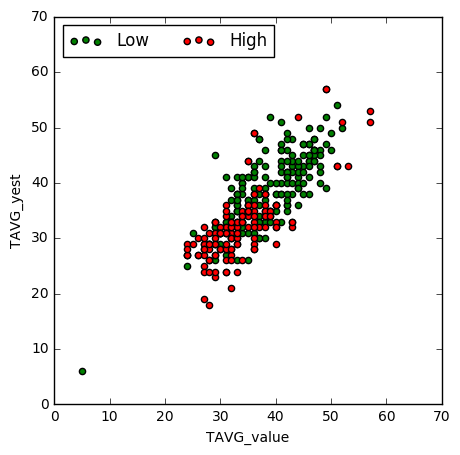

In [344]:
plot_classes(dflimit, x='TAVG_value', y='TAVG_yest')

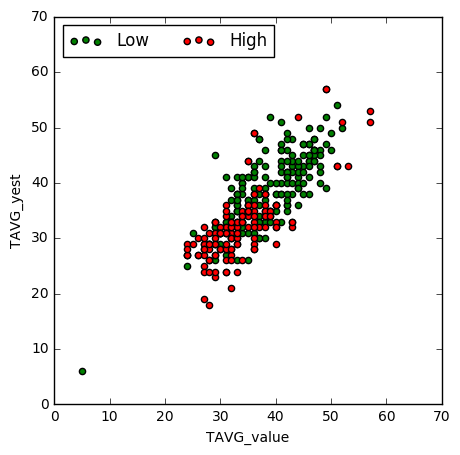

In [345]:
plot_classes(dflimit, x='TAVG_value', y='TAVG_yest')

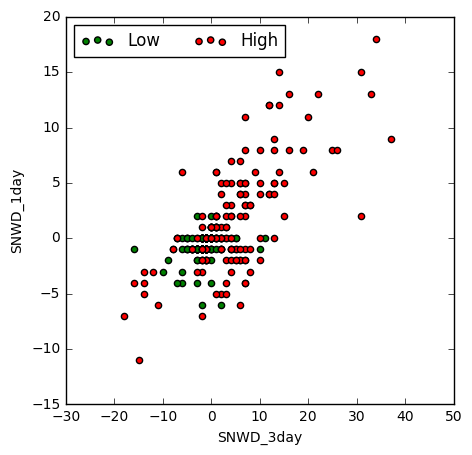

In [346]:
plot_classes(dflimit, x='SNWD_3day', y='SNWD_1day')

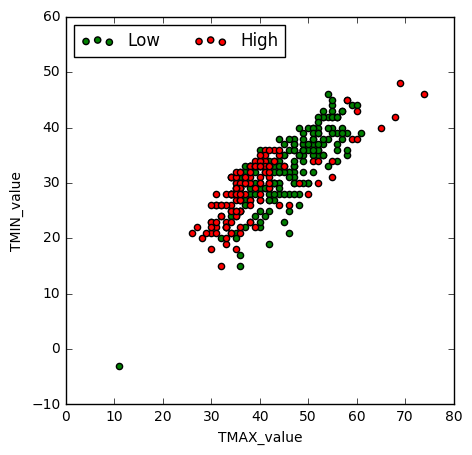

In [347]:
plot_classes(dflimit, x='TMAX_value', y='TMIN_value')

that's pretty good. clustering based on snow depth changing

# modeling

split into training and target sets

In [348]:
dftarget = dflimit['treeline_above']
dftarget.head()

datetime_loc
2014-01-05    1
2014-01-10    4
2014-01-11    4
2014-01-18    1
2014-01-21    1
Name: treeline_above, dtype: float64

In [349]:
nwac_areas

['treeline_above', 'treeline_near', 'treeline_below']

In [350]:
dftrain = dflimit.drop(nwac_areas, axis=1)
dftrain.head()

,TMAX_value,TMIN_value,TAVG_value,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,
2014-01-05,40,33,37,30,0,2,0.0
2014-01-10,35,30,32,30,5,15,1.1
2014-01-11,38,27,31,32,0,10,0.7
2014-01-18,55,44,47,48,0,-1,0.0
2014-01-21,49,37,43,43,-1,-2,0.0


principal component analysis

In [351]:
dftrain.values.shape # n_samples, n_features

(319, 7)

In [352]:
from sklearn.decomposition import PCA
pca = PCA()
pc = pca.fit_transform(dftrain.values)

In [353]:
pca.explained_variance_ratio_

array([  7.61961437e-01,   1.28645023e-01,   5.80994660e-02,
         2.98716224e-02,   1.84758778e-02,   2.32790348e-03,
         6.18671084e-04])

In [354]:
dfp = pd.DataFrame(pc, index = dftrain.index)
dfp.head()

,0,1,2,3,4,5,6
datetime_loc,,,,,,,
2014-01-05,-3.434734,-0.179378,3.144563,-5.163072,0.213090,-0.632582,-0.371109
2014-01-10,-14.791570,-9.758367,-1.851068,-2.586308,1.044505,0.373709,0.047620
2014-01-11,-11.557139,-3.536880,-0.301614,1.173067,3.677912,1.093866,0.113959
2014-01-18,22.747834,-6.179617,-3.084949,-1.325319,0.001662,1.334217,-0.222553
2014-01-21,13.080412,-0.924912,-1.612522,-0.369393,0.411094,-0.583077,-0.163125


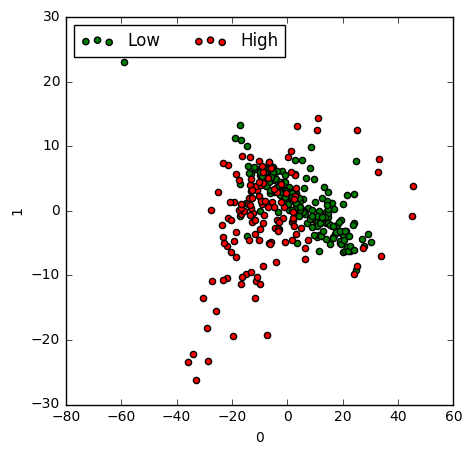

In [355]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=0, y=1)

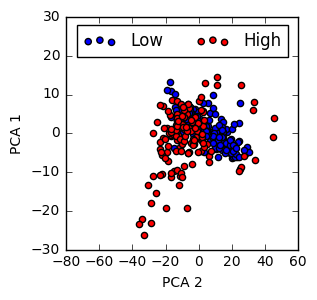

In [356]:
fig = plt.figure(figsize=(3,3))
ax = plt.gca()
plot_classes(pd.concat([dftarget, dfp], axis=1), x=0, y=1)
for coll,c in zip(ax.collections,list('br')):
    coll.set_facecolor(c)
ax.legend(ncol=2, loc='upper center')
ax.set_ylabel('PCA 1')
ax.set_xlabel('PCA 2')

still not very good separation... maybe need new engineered features

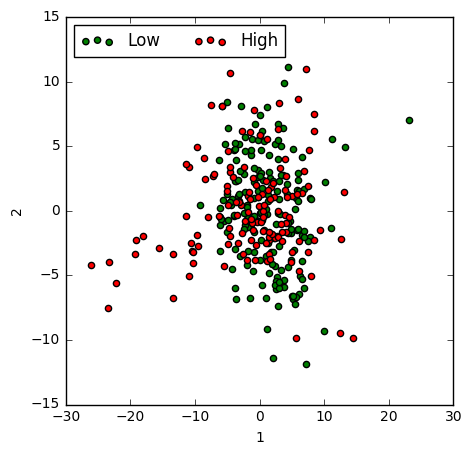

In [357]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=1, y=2)

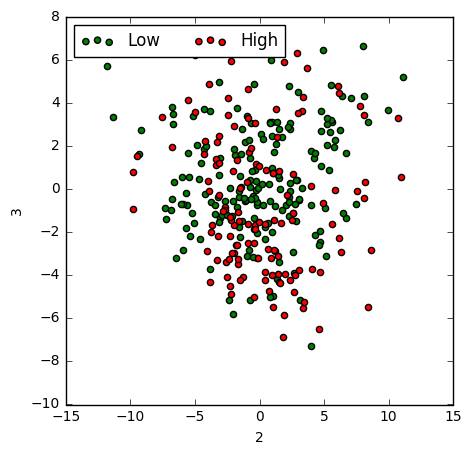

In [358]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=2, y=3)

# train model

without using PCA

In [359]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 1e3, penalty='l2')

model.fit(dftrain, dftarget)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [360]:
from sklearn.svm import SVC
model = SVC(C = 1e6, kernel='rbf')

model.fit(dftrain, dftarget)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [361]:
from sklearn.externals import joblib
joblib.dump(model, 'snotelier/data/filename.pkl') 

['snotelier/data/filename.pkl',
 'snotelier/data/filename.pkl_01.npy',
 'snotelier/data/filename.pkl_02.npy',
 'snotelier/data/filename.pkl_03.npy',
 'snotelier/data/filename.pkl_04.npy',
 'snotelier/data/filename.pkl_05.npy',
 'snotelier/data/filename.pkl_06.npy',
 'snotelier/data/filename.pkl_07.npy',
 'snotelier/data/filename.pkl_08.npy',
 'snotelier/data/filename.pkl_09.npy',
 'snotelier/data/filename.pkl_10.npy',
 'snotelier/data/filename.pkl_11.npy']

In [362]:
from sklearn import metrics
result = model.predict(dftrain)
metrics.accuracy_score(dftarget, result)

1.0

In [363]:
np.mean(result == dftarget.values)

1.0

mega MEGA overfitted!

# cross validation

In [364]:
len(dftarget)

319

In [365]:
from sklearn.cross_validation import KFold

kf = KFold(len(dftarget), n_folds=4)
for train, test in kf:
    
    model = SVC(C = 1e6, kernel='rbf')
    model.fit(dftrain.ix[train], dftarget.ix[train])
    
    result = model.predict(dftrain.ix[test])
    score = metrics.accuracy_score(dftarget.ix[test], result)
    print(score)

0.75
0.8125
0.6375
0.848101265823


Again, substandial variation in sets. Accuracy is improving though.

# try hourly